In [1]:
from RAFT.core.raft import RAFT
from RAFT.core.utils.utils import InputPadder
from torchvision.utils import flow_to_image
import cv2
import torch
import numpy as np
from einops import rearrange
import matplotlib.pyplot as plt
from decord import VideoReader
import numpy.typing as npt

/remote-home1/lzj/miniconda3/envs/lzj/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/remote-home1/lzj/miniconda3/envs/lzj/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/remote-home1/lzj/miniconda3/envs/lzj/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def array_to_video(
    image_array: npt.NDArray, fps: float = 30.0, output_file: str = "output_video.mp4"
) -> None:
    height, width, channels = image_array[0].shape
    fourcc = cv2.VideoWriter_fourcc(*"mp4v")
    video_writer = cv2.VideoWriter(output_file, fourcc, float(fps), (width, height))

    for image in image_array:
        image_rgb = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        video_writer.write(image_rgb)

    video_writer.release()


def custom_to_video(
    x: torch.Tensor, fps: float = 2.0, output_file: str = "output_video.mp4"
) -> None:
    x = x.detach().cpu()
    x = torch.clamp(x, -1, 1)
    x = (x + 1) / 2
    x = x.permute(1, 2, 3, 0).float().numpy()
    x = (255 * x).astype(np.uint8)
    array_to_video(x, fps=fps, output_file=output_file)
    return

In [3]:
class RaftParams():
	def __init__(self) -> None:
		self.small = False
		self.mixed_precision = True
		self.alternate_corr = False
	def __getitem__(self, key):
		return getattr(self, key)
	
	def __setitem__(self, key, value):
		setattr(self, key, value)
	
	def __delitem__(self, key):
		delattr(self, key)
	
	def __contains__(self, key):
		return hasattr(self, key)	
params = RaftParams()
raft = RAFT(params)
ckpt = {key.replace("module.", ""): value for key, value in torch.load("/remote-home1/lzj/causal-video-vae-github/.cache/raft/raft-things.pth").items()}
raft.load_state_dict(ckpt)

<All keys matched successfully>

In [20]:
video_read = VideoReader("/remote-home1/lzj/dataset/gen/opensora1.1_k400_sr1_nf33_res256_subset50/origin/--nQbRBEz2s.mp4")
origin_video_read = VideoReader("/remote-home1/lzj/dataset/gen/opensora1.1_k400_sr1_nf33_res256_subset50/origin/--nQbRBEz2s.mp4")

video = torch.tensor(video_read[:].asnumpy())
video = rearrange(video, "t h w c -> t c h w")
video = video[:, :, :, :]

origin_video = torch.tensor(origin_video_read[:].asnumpy())
origin_video = rearrange(origin_video, "t h w c -> t c h w")
origin_video = origin_video[:, :, :, :]

# _, forward_flow = raft(video[:-1], video[1:], iters=20, test_mode=True)
# _, backward_flow = raft(reversed(video)[:-1], reversed(video)[1:], iters=20, test_mode=True)
# backward_flow = torch.flip(backward_flow, [0])

_, fake_forward_flow = raft(video[:-1], video[1:], iters=20, test_mode=True)
_, gt_forward_flow = raft(origin_video[:-1], origin_video[1:], iters=20, test_mode=True)
print(torch.mean(torch.norm(gt_forward_flow - fake_forward_flow, dim=1)))

tensor(0., grad_fn=<MeanBackward0>)


In [10]:

print((gt_forward_flow - fake_forward_flow).shape)

torch.Size([16, 2, 512, 512])


tensor(0.1286, grad_fn=<MeanBackward0>)


In [66]:
def get_rc_matrix(frame):
    row, col = torch.meshgrid(torch.arange(frame.shape[-2]), torch.arange(frame.shape[-1]), indexing='ij')
    row = row.unsqueeze(0)
    col = col.unsqueeze(0)
    rc_matrix = torch.concat([row, col], dim=0)
    return rc_matrix

def clamp_warp_rc(warp_rc, frame):
    height, width = frame.shape[-2:]
    warp_rc = torch.clamp(warp_rc, min=0)
    warp_rc[:, 0, :, :] = torch.clamp(warp_rc[:, 0, :, :], max=height - 1)
    warp_rc[:, 1, :, :] = torch.clamp(warp_rc[:, 1, :, :], max=width - 1)
    return warp_rc

def get_disocclusion_mask(forward_flow, backward_flow, frame0, frame1):
    """
    http://arxiv.org/abs/1604.08610
    """
    num_frames = frame0.shape[0]
    rc_matrix = get_rc_matrix(frame0)
    
    warp_rc = rc_matrix + backward_flow
    warp_rc = clamp_warp_rc(warp_rc, frame0)
    warp_rc = warp_rc.long()
    warp_forward_flow = torch.zeros_like(backward_flow) # T V H W
    
    for t in range(num_frames):
        warp_forward_flow[t, :, warp_rc[t, 0], warp_rc[t, 1]] += forward_flow[t]
        
    # Formula (4)
    mask = torch.square(torch.norm(warp_forward_flow + backward_flow, dim=1)) <= 0.01 * (torch.square(torch.norm(warp_forward_flow, dim=1)) + torch.square(torch.norm(backward_flow, dim=1))) + 0.5
    
    return mask
    
def warp_frame(forward_flow, frame0):
    num_frames = frame0.shape[0]
    rc_matrix = get_rc_matrix(frame0)
    warp_frame = torch.zeros_like(frame0)
    warp_rc = forward_flow + rc_matrix
    warp_rc = clamp_warp_rc(warp_rc, frame0)
    warp_rc = warp_rc.long()
    for t in range(num_frames):
        warp_frame[t, :, warp_rc[t, 0], warp_rc[t, 1]] = frame0[t]
    return warp_frame
    
def cal_warp_error(forward_flow, backward_flows, video):
    num_frames = video.shape[0]
    disocclusion_mask = get_disocclusion_mask(forward_flow, backward_flow, video[:-1], video[1:])
    disocclusion_mask = disocclusion_mask.long()
    warp_frames = warp_frame(forward_flow, video[:-1])
    video = video.to(dtype=torch.float)
    warp_frames = warp_frames.to(dtype=torch.float)
    warp_error = torch.mean(torch.sum(torch.norm(video[:-1] - warp_frames, dim=1) * disocclusion_mask, dim=(1,2)) / torch.sum(disocclusion_mask, dim=(1,2)))
    return warp_error

warp_error = cal_warp_error(forward_flow, backward_flow, origin_video / 255)
print(warp_error)

tensor(0.1124)


NameError: name 'warp_frames' is not defined

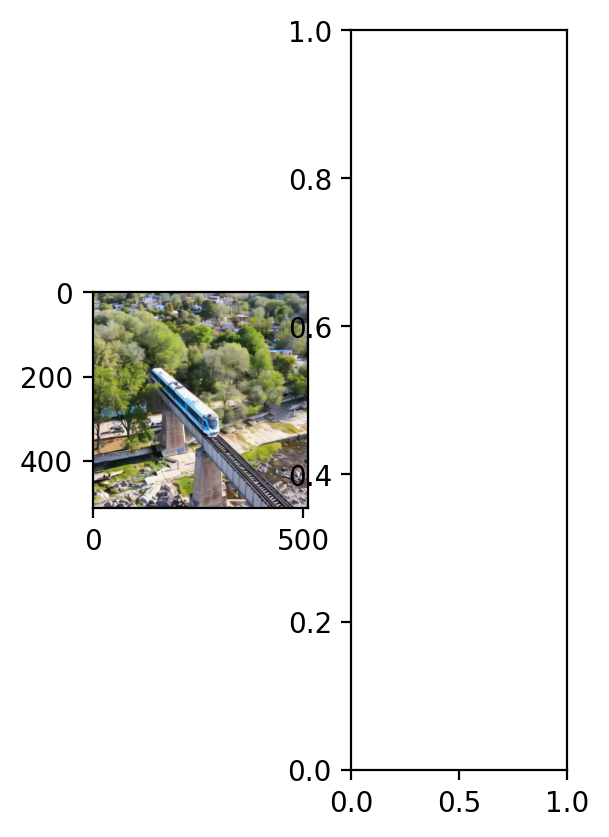

In [65]:
frame_idx = 3
plt.figure(dpi=200)
plt.subplot(1, 4, 1)
plt.imshow(video[frame_idx].permute(1,2,0))
plt.subplot(1, 4, 2)
plt.imshow(warp_frames[frame_idx - 1].permute(1,2,0))
plt.subplot(1, 4, 3)
mask_image = disocclusion_mask[frame_idx - 1].long() * 255
plt.imshow(mask_image.unsqueeze(0).repeat((3,1,1)).permute(1,2,0))
plt.subplot(1, 4, 4)
mask_on_warp_frames = warp_frames[frame_idx - 1].clone()
mask_on_warp_frames[:, disocclusion_mask[frame_idx - 1]] = 0
plt.imshow(mask_on_warp_frames.permute(1,2,0))

In [20]:
torch.norm(torch.tensor([[0,1], [1,2]]), dim=1)

RuntimeError: linalg.vector_norm: Expected a floating point or complex tensor as input. Got Long

In [264]:
forward_flow > 10

tensor([[[[False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          ...,
          [False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False]],

         [[False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          ...,
          [False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False]]],


        [[[False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          ...,
          [False, False, False,  ..., False, Fals